In [1]:
import scipy.signal as signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Import recorded raw data

In [2]:
# Load Row data into pandas
#df = pd.read_csv("data/rawdata_2019-11-09T19:59:51-slow.csv", names =['time', 'accX', 'accY', 'accZ', 'accuracy'])
df = pd.read_csv("data/rawdata_2019-11-09T20:01:46-fast.csv", names =['time', 'accX', 'accY', 'accZ', 'accuracy'])
# df = pd.read_csv("data/rawdata_2019-11-09T22:40-mixed.csv", names =['time', 'accX', 'accY', 'accZ', 'accuracy'])

## Data processing
Basically the same as Kotlin class 

In [6]:
# parameters:
n = 70       # the larger n is, the smoother curve will be
n_avg = 500 # elements used to calculate average
band_width = 0.08  # 

# Make time starting from 0 and convert to ms
init_time = df.time[0]
df.time = (df.time - init_time)/1e6

# Calculate magnitude of acceleration vector
df['accM'] = np.sqrt(df.accX*df.accX + df.accY*df.accY + df.accZ*df.accZ) 

# Filter with moving average over n elements 
b = [1.0 / n] * n
a = 1
df['filtered'] = signal.lfilter(b,a,df['accM'])

# Calculate average of last 2000 elements
b = [1.0 / n_avg] * n_avg
a = 1
df['running_avg'] = signal.lfilter(b,a,df['filtered'])

# Define limits
df['upperlimit'] = df['running_avg']*(1 + band_width/2.0)
df['lowerlimit'] = df['running_avg']*(1 - band_width/2.0)

# Detect when limits are crossed
rows_list = []
isBelow = False

for tuple in df.itertuples(): 
    if isBelow and tuple.filtered > tuple.upperlimit:
        isBelow = False
    
    if (not isBelow) and (tuple.filtered < tuple.lowerlimit) :
        isBelow = True
        rows_list.append({'time': tuple.time, 'value': tuple.filtered})

df2 = pd.DataFrame(rows_list)          

## Plot found beginnings of period

135790


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


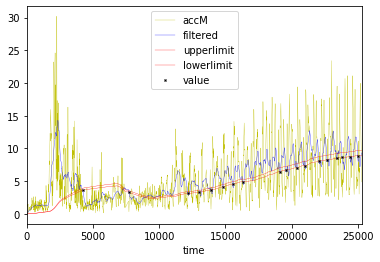

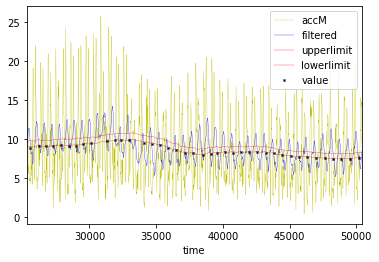

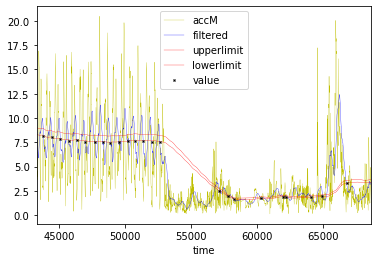

In [4]:
print(df.size)

n_windows = int(df.time.size/5000)+1

for i in range(n_windows):
    # Limit data to certain window
    df_part = df.head(5000*(1+i)).tail(5000)
    start = df_part.time.iloc[0]
    end = df_part.time.iloc[-1]
    df2_part = df2[(start < df2['time']) & (df2['time'] < end)] 
    
    ax = df_part.plot(x = 'time', y=['accM', 'filtered', 'upperlimit', 'lowerlimit'], color ='ybrr', kind = 'line', linewidth=0.3)
    
    df2_part.plot(x='time', y='value', linestyle='None', marker='x', color='k', markersize=2, ax=ax)
    plt.savefig('fast-detection'+str(i)+'.eps', format='eps')

## Calcuate Cadence

In [5]:
## Calculate Cadence
period = df2.time.diff()[1:]

cadence = 6*period/100

n_different_cadences =0
for i in range(2,cadence.size):
    d = cadence[i]/cadence[i-1]
    if d < 0.8 or d > 1.2:
        n_different_cadences += 1

print(cadence[cadence>250])
# print(n_different_cadences/cadence.size)

2     267.271730
62    270.272827
Name: time, dtype: float64
